# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/FindingDorri/CS39AA--Project/blob/main/project_part1.ipynb)


## Introduction/Background

The NLP Problem I'm trying tackle for this project is __image classification__. The dataset is from the Dog vs.Cats Redux: Kernels Edition Competition on Kaggle. This dataset is split into training and testing data with 25,000 and 12,500 images of dog and cat respectively. The data is named according to a numeric id along with the label as part of the file name. For example, a picture of a cat could be "cat.100.jpg". This is a image classification problem because the goal of this task is to assign an input image with a label as either cat or dog(1 = dog, 0 = cat). To a computer, an image is represented as one large 3-dimensional array of numbers. Take this image of a dog for example, it is 320 pixels wide, 239 pixels tall, and has three color channels Red,Green,Blue (or RGB for short). Therefore, the image consists of 248 x 400 x 3 numbers, or a total of 229,440 numbers. Each number is an integer that ranges from 0 (black) to 255 (white). The task is to turn this quarter of a million numbers into a single label, such as “dog”.

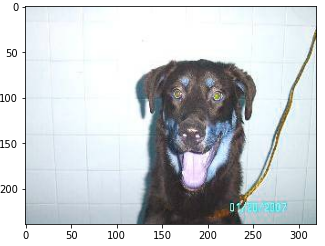


## Exploratory Data Analysis

Now that we have a better understanding of what problem we're tackling, let's take a quick look at our data. Since the label for each images is in the image's name, we'll need to extract it.

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname,filename)
base_dir = "../input/catvsdog"
train_dir = os.path.join(base_dir, "train/train")

In [28]:
train_filenames = os.listdir(base_dir+ '/train/train')

train = pd.DataFrame(columns=['path', 'label'])
train['path'] = train_filenames
train['numeric_id'] = train['path'].str[4:-4] # Create seperate column for the extracted 
train['label'] = train['path'].str[0:3]
train['path'] = train_dir +"/" +train['path']
train.head()

path label numeric_id
0  ../input/catvsdog/train/train/cat.12461.jpg   cat      12461
1   ../input/catvsdog/train/train/dog.3443.jpg   dog       3443
2   ../input/catvsdog/train/train/dog.7971.jpg   dog       7971
3  ../input/catvsdog/train/train/dog.10728.jpg   dog      10728
4   ../input/catvsdog/train/train/dog.1942.jpg   dog       1942

<AxesSubplot:>

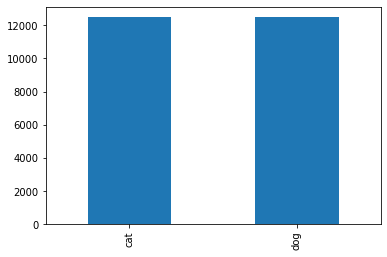

In [3]:
train.label.value_counts().plot.bar() # Balanced Data

We can confirm here that there are 25,000 images in the train dataset and 12,500 images of dog and cat. Let's take a look at some of them!

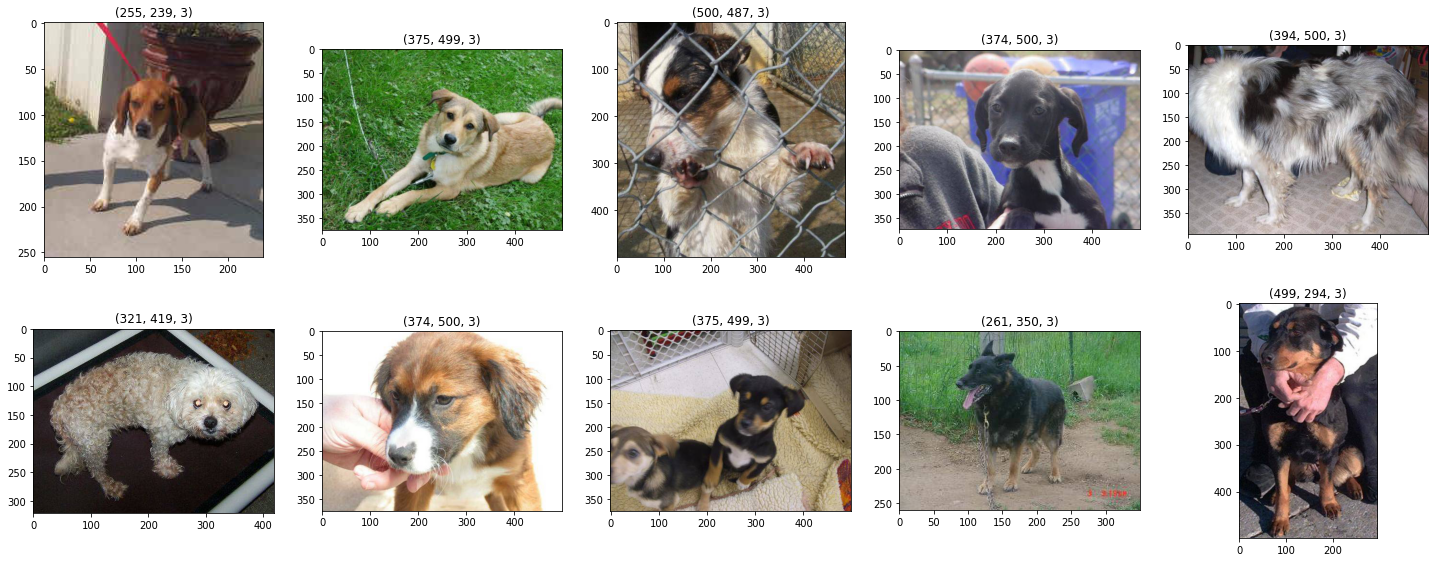

In [29]:
plt.figure(figsize=(25,25))
temp = train[train['label']=='dog']['path']
start = random.randint(0,len(temp))
files = temp[start:start + 10]
for index,file in enumerate(files):
    plt.subplot(5,5,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(img.shape)

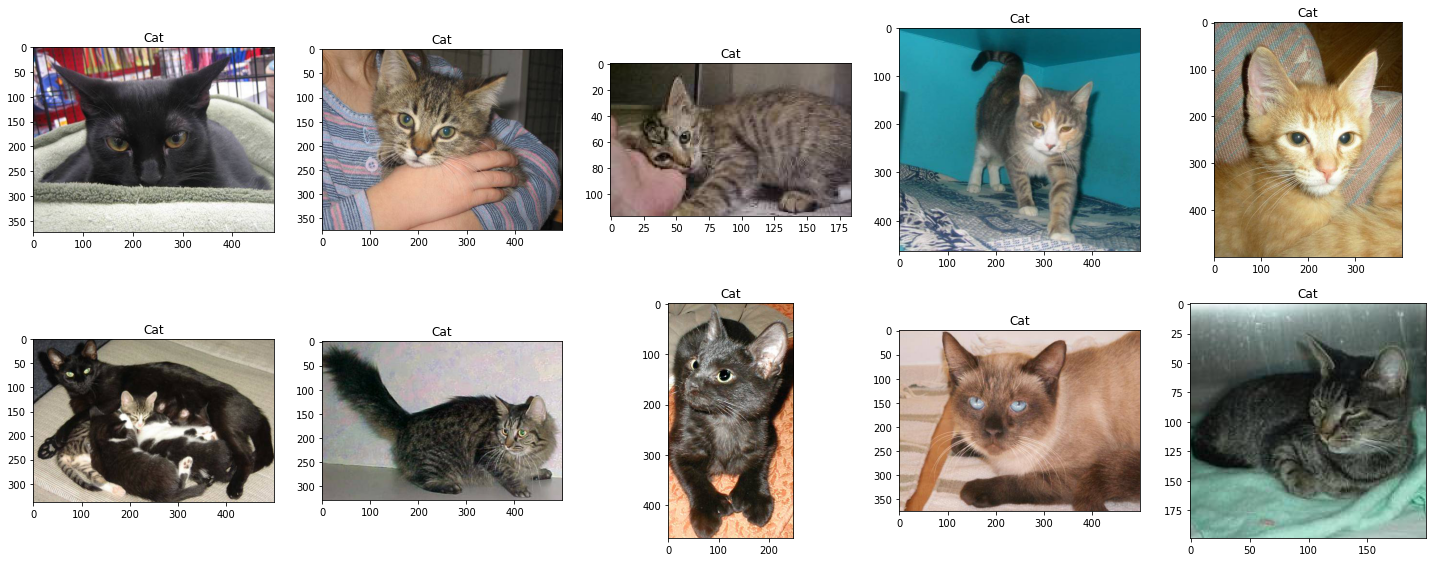

In [30]:
plt.figure(figsize=(25,25))
temp = train[train['label']=='cat']['path']
files = temp[start:start + 10]
for index,file in enumerate(files):
    plt.subplot(5,5,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Cat')

Cuteness overload! Ten pictures of each class is displayed above. One thing that stands out right away is that the pictures have different dimensions. The best way to deal with different sized images is to downscale them to match dimensions from the smallest image available. The reasons for doing this include the memory limitations on the GPU. At high resolution, we have to reduce the batch size and at the same time training is slower. Also, mini-batch gradient descent requires inputs to be of the same size. However, by doing so this will degrade the quality of picture as we scale them to smaller dimension. Thus, there will be less pixels to convey information about the picture. This also denote that images will appear more blurry than when it's at its original dimension. 

Speaking of blurriness, let's take a look at our dataset and measure how blurry our images are using the Laplace filter.The Laplace filter is mainly used to define the edge lines in a picture. What is meant here by the edge are the sharp color separations that usually separate objects from the background. The Laplace filter, also known as the Sharpening Filter, uses a window while operating. This window is often refered as kernel. Laplacian filter kernels usually contain negative values in a cross pattern, centered within the array. The corners are either zero or positive values. The center value can be either negative or positive. You simply take a single channel of an image (presumably grayscale) and convolve it with the following 3 x 3 kernel:


$\left[\begin{array}{ccc}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0
\end{array}\right]$

And then take the variance (i.e. standard deviation squared) of the response. If the variance falls below a pre-defined threshold, then the image is considered blurry; otherwise, the image is not blurry.

Here's a quick look of the range in width and height of our dataset.

In [32]:
import cv2 as cv
training_data=[]
traing_data_blur=[]
for images in os.listdir(train_dir):
    img_array =cv.imread(os.path.join(train_dir,images),cv.IMREAD_UNCHANGED)
    training_data.append((img_array.shape[0],img_array.shape[1]))# get width and height of all pictures to plot
    gray = cv.cvtColor(img_array,cv.COLOR_BGR2RGB)
    fn = cv.Laplacian(gray,cv.CV_64F).var()
    traing_data_blur.append(fn)

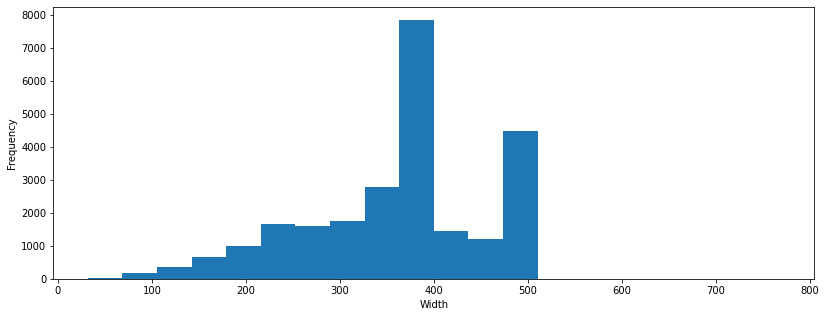

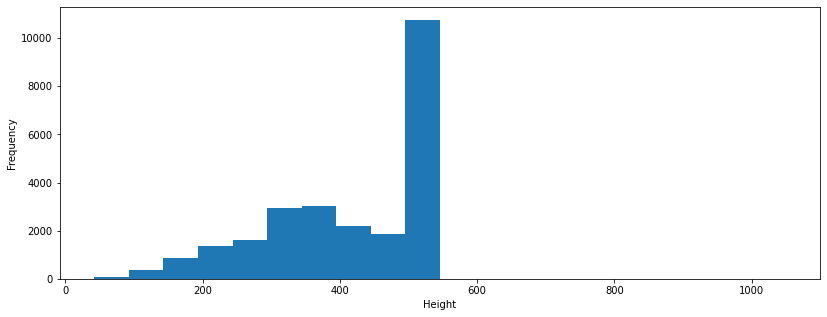

In [44]:
x_val = [x[0] for x in training_data] # width
y_val = [x[1] for x in training_data] # height

plt.figure(figsize=(30,5))
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.hist(x_val,bins=20)

plt.figure(figsize=(30,5))
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 1
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.hist(y_val,bins=20);

In [7]:
print("Max height:", max(training_data,key=lambda item:item[1])[1])
print("Min height:", min(training_data,key=lambda item:item[1])[1])
print("Max width:", max(training_data,key=lambda item:item[0])[0])
print("Min width:", min(training_data,key=lambda item:item[0])[0])


Max height: 1050
Min height: 42
Max width: 768
Min width: 32


Here we'll calculate the score of bluriness of the first few pictures. The assumption here is that if an image contains high variance then there is a wide spread of responses, both edge-like and non-edge like, representative of a normal, in-focus image. But if there is very low variance, then there is a tiny spread of responses, indicating there are very little edges in the image. As we know, the more an image is blurred, the less edges there are.

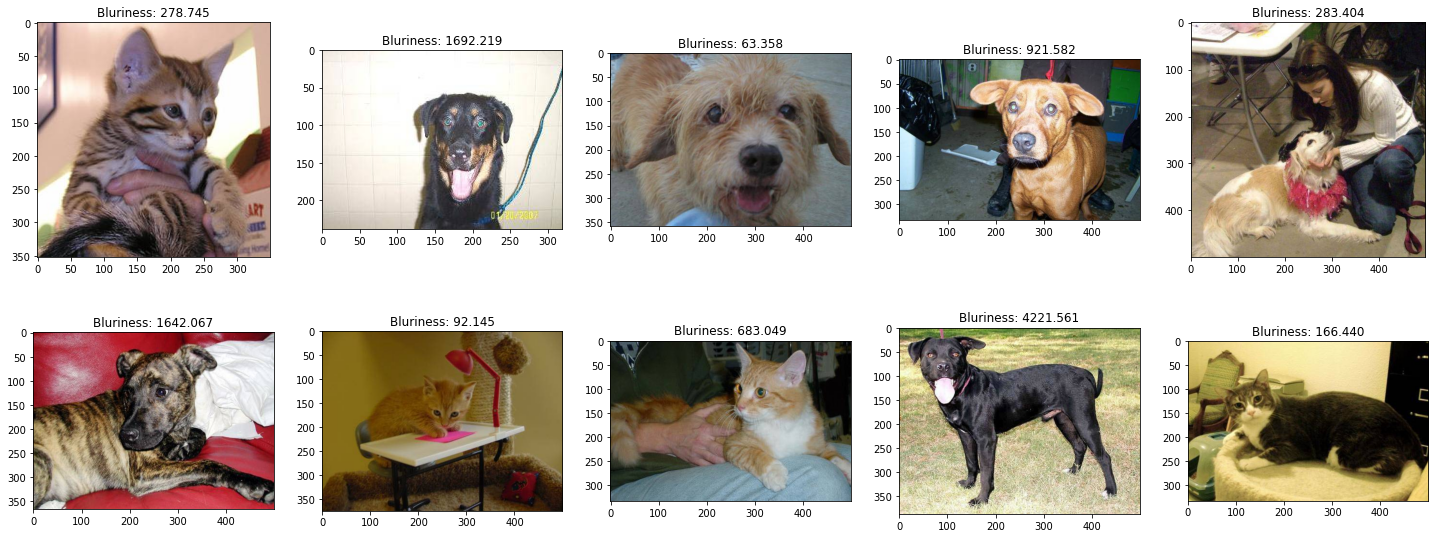

In [10]:
plt.figure(figsize=(25,25))

for index,images in enumerate(os.listdir(train_dir)):
    if index == 10:
        break
    img_array =cv.imread(os.path.join(train_dir,images),cv.IMREAD_UNCHANGED)
    gray = cv.cvtColor(img_array,cv.COLOR_BGR2RGB)
    fn = cv.Laplacian(gray,cv.CV_64F).var()
    plt.subplot(5,5,index + 1)
    plt.imshow(gray)
    plt.title("Bluriness: " + "{0:.3f}".format(fn))

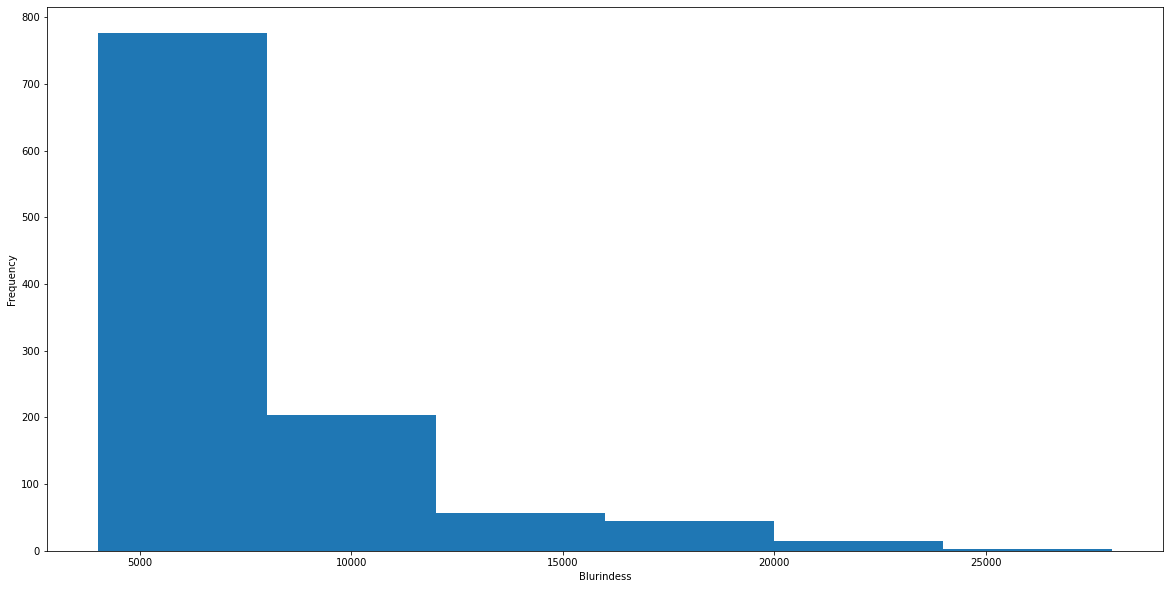

In [41]:
plt.figure(figsize=(20,10))
plt.xlabel("Blurindess")
plt.ylabel("Frequency")
# plt.xticks(np.arange(0, 20000, 1000))
plt.hist(traing_data_blur,bins=[4000,8000,12000,16000,20000,24000,28000]);

For this next observation, I wanted to take a closer look at the dataset to see whether there's any errors or not. I mean who wouldn't want to scroll through a folder full of images of cats and dogs. By doing this, I found some interesting pictures that could affect the training of our model. 
Since this is a fairly big dataset, would some error data affect the learning of our model? If so, how drastically?

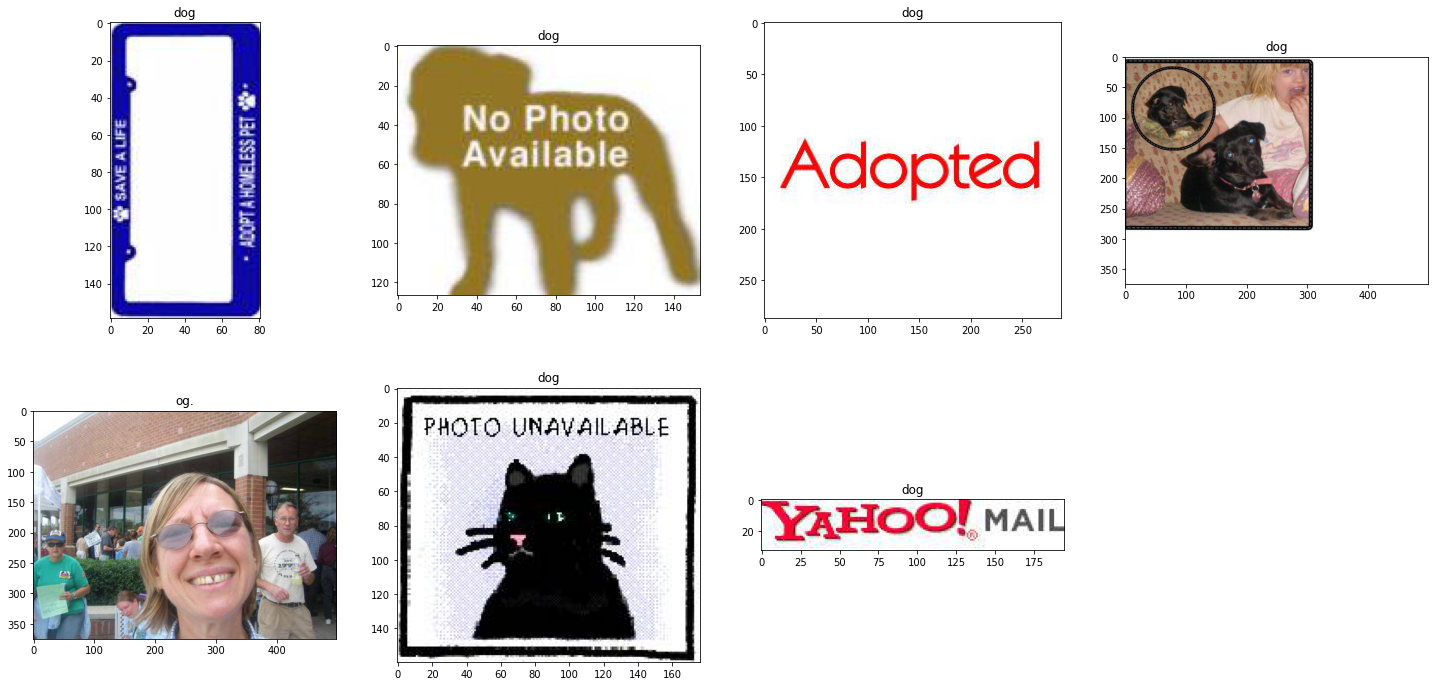

In [18]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['9517','8898','8736','4367','2877','2146','12376']) & (train['label'] == 'dog') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('dog')

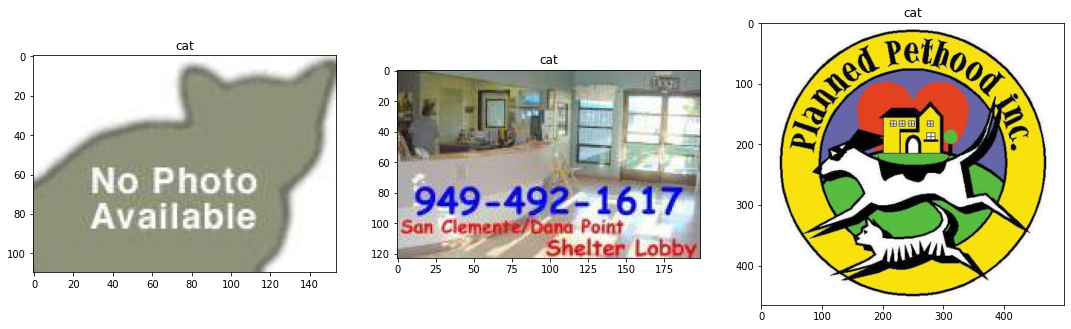

In [25]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['4688','4338','3216']) & (train['label'] == 'cat') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('cat')

As we can see from the pictures displayed above, there's quite a few that shows something that we're not training out model to predict. There's also picture labled as "cat", however, it contains both cat and dog.Also, I've not taken a close look at every picture in the dataset we're using. These are some pictures that I was able to spot out after a quick skim.


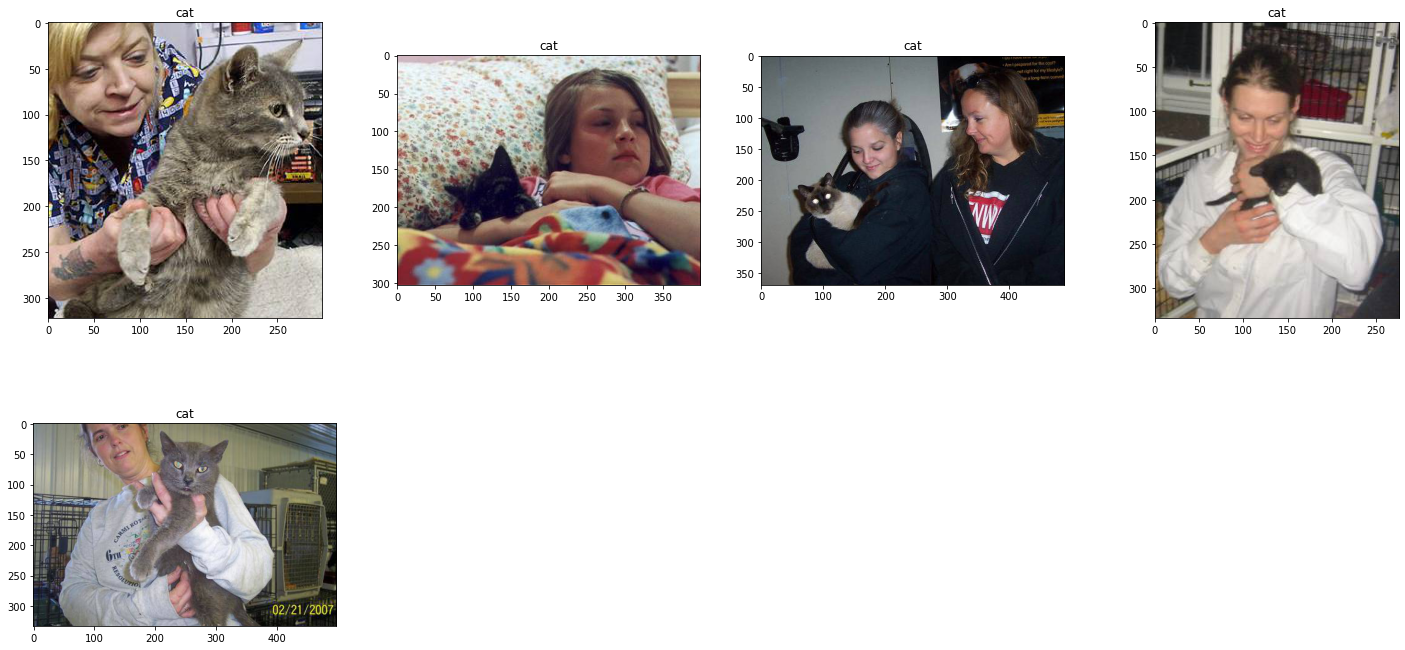

In [26]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['973','859','372','257','6']) & (train['label'] == 'cat') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('cat')

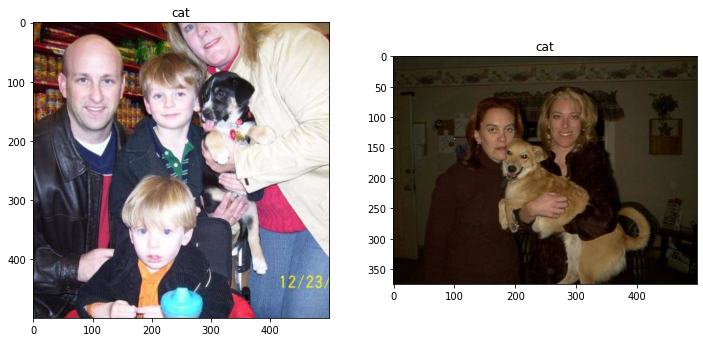

In [29]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['12491','12293']) & (train['label'] == 'dog') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('dog')

Above is pictures that contain people in the background rather than just the object we're trying to identify. Potential errors?

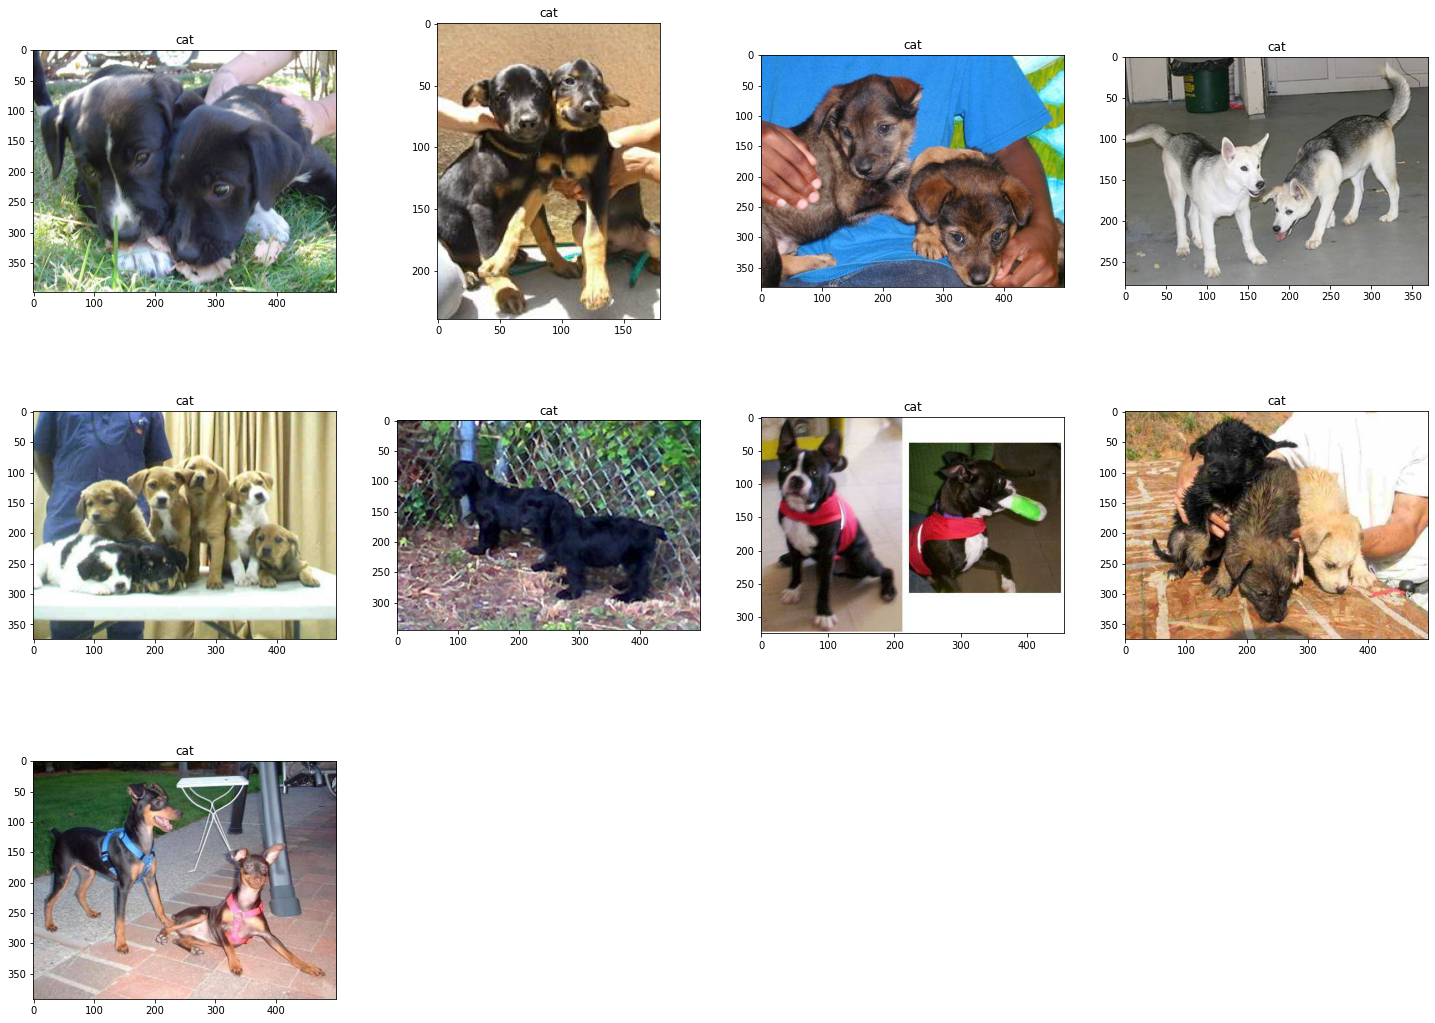

In [28]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['12497','12471','12446','12445','12438','12425','12413','12400','12291']) & (train['label'] == 'dog') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('cat')

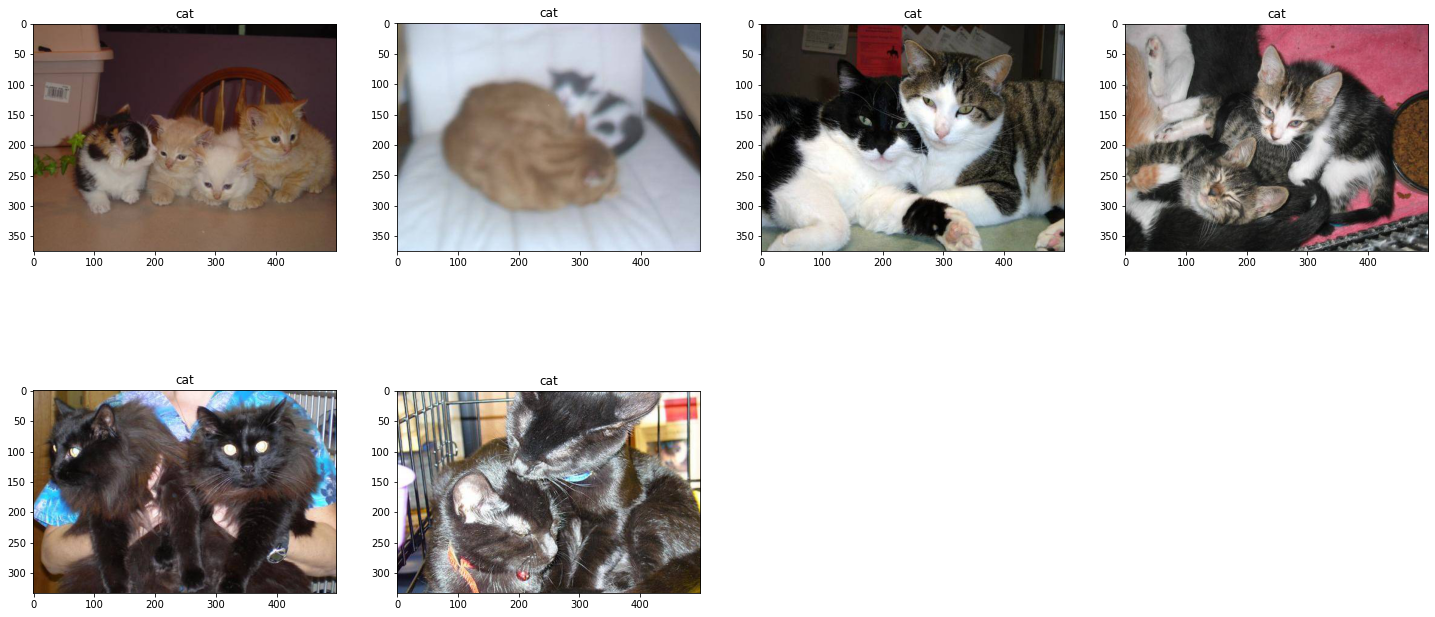

In [31]:
plt.figure(figsize=(25,25))
files = train[train['numeric_id'].isin(['960','976','984','1025','1049','241']) & (train['label'] == 'cat') ]['path']
for index,file in enumerate(files):
    plt.subplot(4,4,index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('cat')


Another observation from the images displayed above is background. According to this [article](https://gradientscience.org/background/), they observed that computer vision models tend to over-rely on image backgrounds in image classification. On one hand, their findings provide more evidence that our models are not fully aligned with the human vision system. On the other hand, it was shown that advances in computer vision models, such as new architectures and training methods, have led to models that tend to use the foreground more effectively and are more robust to misleading backgrounds. 
